In [1]:
import os
import argparse
from utils import bool_ext, load_dataset, split_dataset, evaluate, checkCorrelations
from models import CITRUS
import pickle
import torch
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    device_name = torch.cuda.get_device_name(0)
else:
    device_name = 'cpu'


parser = argparse.ArgumentParser()

parser.add_argument(
    "--input_dir", 
    help="directory of input files", 
    type=str, 
    default="./data"
)
parser.add_argument(
    "--output_dir",
    help="directory of output files",
    type=str,
    default="./output",
)
parser.add_argument(
    "--embedding_size",
    help="embedding dimension of genes and tumors",
    type=int,
    default=512,
)
parser.add_argument(
    "--hidden_size", 
    help="hidden layer dimension of MLP decoder", 
    type=int, 
    default=400
)
parser.add_argument(
    "--attention_size", 
    help="size of attention parameter beta_j", 
    type=int, 
    default=256
)
parser.add_argument(
    "--attention_head", 
    help="number of attention heads", 
    type=int, 
    default=32
)
parser.add_argument(
    "--learning_rate", 
    help="learning rate for Adam", 
    type=float, 
    default=1e-3
)
parser.add_argument(
    "--max_iter", 
    help="maximum number of training iterations", 
    type=int, 
    default=1000
)
parser.add_argument(
    "--max_fscore",
    help="Max F1 score to early stop model from training",
    type=float,
    default=0.7
)
parser.add_argument(
    "--batch_size", 
    help="training batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_batch_size", 
    help="test batch size", 
    type=int, 
    default=100
)
parser.add_argument(
    "--test_inc_size",
    help="increment interval size between log outputs",
    type=int,
    default=256
)
parser.add_argument(
    "--dropout_rate", 
    help="dropout rate", 
    type=float, 
    default=0.2
)
parser.add_argument(
    "--input_dropout_rate", 
    help="dropout rate", 
    type=float, 
    default=0.2
)
parser.add_argument(
    "--weight_decay", 
    help="coefficient of l2 regularizer", 
    type=float, 
    default=1e-5
)
parser.add_argument(
    "--activation",
    help="activation function used in hidden layer",
    type=str,
    default="tanh",
)
parser.add_argument(
    "--patience", 
    help="earlystopping patience", 
    type=int, 
    default=30
)
parser.add_argument(
    "--mask01",
    help="wether to ignore the float value and convert mask to 01",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--gep_normalization", 
    help="how to normalize gep", 
    type=str, 
    default="scaleRow"
)
parser.add_argument(
    "--attention",
    help="whether to use attention mechanism or not",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--cancer_type",
    help="whether to use cancer type or not",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--train_model",
    help="whether to train model or load model",
    type=bool_ext,
    default=True,
)
parser.add_argument(
    "--dataset_name",
    help="the dataset name loaded and saved",
    type=str,
    default="dataset_CITRUS",
)
parser.add_argument(
    "--tag", 
    help="a tag passed from command line", 
    type=str, 
    default=""
)
parser.add_argument(
    "--run_count", 
    help="the count for training", 
    type=str, 
    default="1"
)


args = parser.parse_args([])

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

print("Loading dataset...")
dataset, dataset_test = load_dataset(
    input_dir=args.input_dir,
    mask01=args.mask01,
    dataset_name=args.dataset_name,
    gep_normalization=args.gep_normalization,
)


_df = pd.read_csv('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/data/brca_tcga_pan_can_atlas_2018_clinical_data.tsv', sep='\t')

# dataset['can'] = dataset['can'] + 5

# for tmr, subtype in _df[['Patient ID', 'Subtype']].values:
#     if tmr in dataset['tmr']:
#         if subtype == 'BRCA_LumA':
#             dataset['can'][dataset['tmr'].index(tmr)] = 1
#         if subtype == 'BRCA_LumB':
#             dataset['can'][dataset['tmr'].index(tmr)] = 2
#         if subtype == 'BRCA_Basal':
#             dataset['can'][dataset['tmr'].index(tmr)] = 3
#         if subtype == 'BRCA_her2':
#             dataset['can'][dataset['tmr'].index(tmr)] = 4
#         if subtype == 'BRCA_Normal':
#             dataset['can'][dataset['tmr'].index(tmr)] = 5

from utils import Data       
ddata = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
)

brca = pd.DataFrame(ddata.sga_sga.loc[ddata.cancerType_sga[ddata.cancerType_sga['type']=='BRCA'].index])

wt = brca[(brca['SM_PIK3CA'] == 0) & (brca['SCNA_PIK3CA'] == 0)]
sm_mut = brca[(brca['SM_PIK3CA'] == 1) & (brca['SCNA_PIK3CA'] == 0)]
scna_mut = brca[(brca['SM_PIK3CA'] == 0) & (brca['SCNA_PIK3CA'] == 1)]
sm_scna_mut = brca[(brca['SM_PIK3CA'] == 1) & (brca['SCNA_PIK3CA'] == 1)]
wt.shape, sm_mut.shape, scna_mut.shape, sm_scna_mut.shape   
            
dataset['can'] = dataset['can'] + 4
for r in brca.iterrows():
    if r[0] not in dataset['tmr']:
        continue
        
    sm, scna = bool(r[1]['SM_PIK3CA']), bool(r[1]['SCNA_PIK3CA'])
    
    if not sm and not scna:
        dataset['can'][dataset['tmr'].index(r[0])] = 1
    
    elif sm and not scna:
        dataset['can'][dataset['tmr'].index(r[0])] = 2
        
    elif not sm and scna:
        dataset['can'][dataset['tmr'].index(r[0])] = 3
        
    elif sm and scna:
        dataset['can'][dataset['tmr'].index(r[0])] = 4
        

train_set, test_set = split_dataset(dataset, ratio=0.66)

args.can_size = dataset["can"].max()  # cancer type dimension
args.sga_size = dataset["sga"].max()  # SGA dimension
args.gep_size = dataset["gep"].shape[1]  # GEP output dimension
args.num_max_sga = dataset["sga"].shape[1]  # maximum number of SGAs in a tumor

args.hidden_size = dataset["tf_gene"].shape[0]
print("Hyperparameters:")
print(args)
args.tf_gene = dataset["tf_gene"]


# masks = np.load('./pnet_prostate_paper/train/maps.npy', allow_pickle=True)

# model = CITRUS(args, masks)  # initialize CITRUS model
# model.build(device=device)  # build CITRUS model
# model.to(device)

# models = []
# for i in [1, 2, 3]:
#     model = CITRUS(args, masks)  # initialize CITRUS model
#     model.build(device=device)  # build CITRUS model

#     model.load_state_dict(torch.load(f'/ihome/hosmanbeyoglu/kor11/tools/CITRUS/output/trained_modelx{i}.pth', 
#                         map_location=torch.device('cpu')))
#     model.eval()
    
#     models.append(model)

Loading dataset...
Hyperparameters:
Namespace(activation='tanh', attention=True, attention_head=32, attention_size=256, batch_size=100, can_size=21, cancer_type=True, dataset_name='dataset_CITRUS', dropout_rate=0.2, embedding_size=512, gep_normalization='scaleRow', gep_size=5541, hidden_size=320, input_dir='./data', input_dropout_rate=0.2, learning_rate=0.001, mask01=True, max_fscore=0.7, max_iter=1000, num_max_sga=1396, output_dir='./output', patience=30, run_count='1', sga_size=11998, tag='', test_batch_size=100, test_inc_size=256, train_model=True, weight_decay=1e-05)


In [2]:
masks = np.load('./pnet_prostate_paper/train/maps.npy', allow_pickle=True)
 
model = CITRUS(args, masks)  # initialize CITRUS model
model.build(device=device)  # build CITRUS model
model.to(device)

model.load_state_dict(torch.load(f'/ihome/hosmanbeyoglu/kor11/tools/CITRUS/output/biomodel.pth', 
                    map_location=torch.device('cpu')))
model.eval()

CITRUS(
  (layer_sga_emb): Embedding(11999, 512, padding_idx=0)
  (layer_can_emb): Embedding(22, 512, padding_idx=0)
  (layer_w_0): Linear(in_features=512, out_features=256, bias=True)
  (layer_beta): Linear(in_features=256, out_features=32, bias=True)
  (layer_dropout_1): Dropout(p=0.2, inplace=False)
  (layer_w_1): Linear(in_features=512, out_features=447, bias=True)
  (layer_dropout_2): Dropout(p=0.2, inplace=False)
  (layer_w_2): Linear(in_features=320, out_features=5541, bias=True)
  (processes): Linear(in_features=447, out_features=1066, bias=True)
  (pathways): Linear(in_features=1066, out_features=1387, bias=True)
  (genes): Linear(in_features=1387, out_features=320, bias=True)
  (loss): MSELoss()
)

In [3]:
from utils import Data

data = Data(
    fGEP_SGA = 'data/CITRUS_GEP_SGAseparated.csv',
    fgene_tf_SGA = 'data/CITRUS_gene_tf_SGAseparated.csv',
    fcancerType_SGA = 'data/CITRUS_canType_SGAseparated.csv',
    fSGA_SGA = 'data/CITRUS_SGA_SGAseparated.csv',
    # cancer_type='BRCA'
)

d = data.cancerType_sga.loc[dataset['tmr']]
d['index'] = dataset['can'].reshape(-1)

In [1]:
preds, tf, hid_tmr, emb_tmr, emb_sga, attn_wt  = model.forward(torch.tensor(dataset['sga']), torch.from_numpy(dataset['can']))

NameError: name 'model' is not defined

In [4]:
# dataset['can'] = dataset['can'] + 5

# for tmr, subtype in _df[['Patient ID', 'Subtype']].values:
#     if tmr in dataset['tmr']:
#         if subtype == 'BRCA_LumA':
#             dataset['can'][dataset['tmr'].index(tmr)] = 1
#         if subtype == 'BRCA_LumB':
#             dataset['can'][dataset['tmr'].index(tmr)] = 2
#         if subtype == 'BRCA_Basal':
#             dataset['can'][dataset['tmr'].index(tmr)] = 3
#         if subtype == 'BRCA_her2':
#             dataset['can'][dataset['tmr'].index(tmr)] = 4
#         if subtype == 'BRCA_Normal':
#             dataset['can'][dataset['tmr'].index(tmr)] = 5

In [5]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
indexes = []
brca_subs = []

for tmr, subtype in _df[['Patient ID', 'Subtype']].values:
    if tmr in dataset['tmr']:
        indexes.append(dataset['tmr'].index(tmr))
        brca_subs.append(subtype)

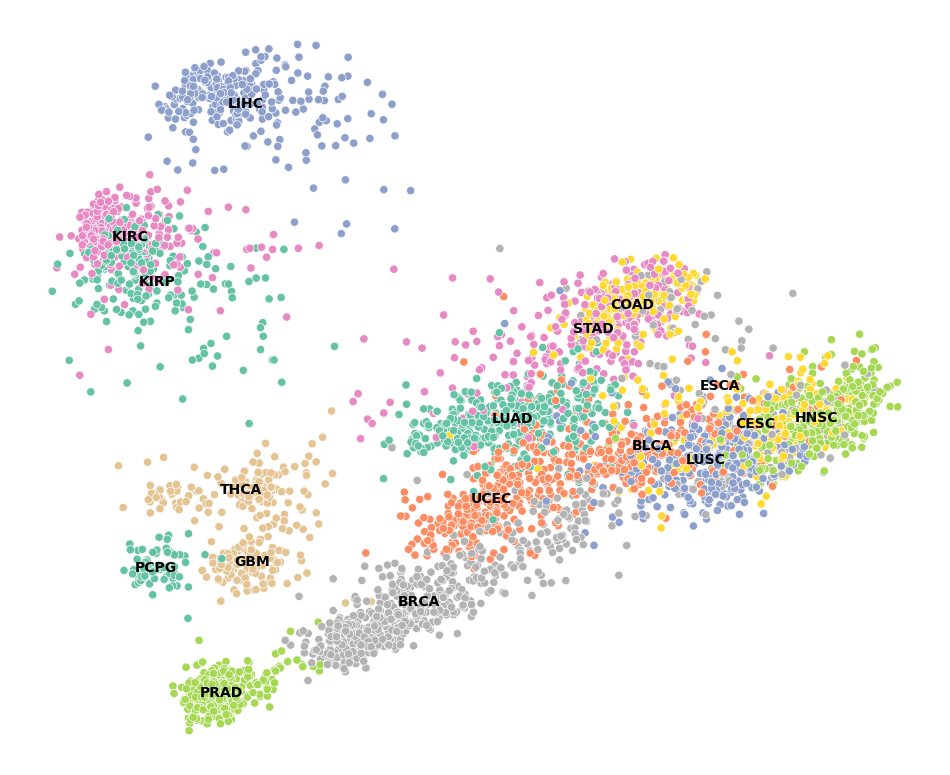

In [7]:
pca = PCA(n_components=2)
pca.fit(x.detach().cpu().numpy())
pca.explained_variance_ratio_
dff = pd.DataFrame(pca.transform(x.detach().cpu().numpy()))
dff.columns = ['PC1', 'PC2']
dff['cancer'] = d.loc[dataset['tmr']]['type'].values

# for ix, iy in zip(indexes, brca_subs):
#     dff.loc[ix, 'cancer'] = iy


fig, ax = plt.subplots(figsize=(12, 10), dpi=100)

sns.scatterplot(data=dff, x='PC1', y='PC2', hue='cancer', ax=ax, palette='Set2')

for r in dff.groupby('cancer').mean().iterrows():
    label = r[0]
    if label != 'BRCA' or label == 'BRCA':
        ax.annotate(r[0], 
                (r[1].PC1, r[1].PC2),
                horizontalalignment='center',
                verticalalignment='center',
                size=10, weight='bold',)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

ax.get_legend().remove()
plt.axis('off')
# plt.title('Pathways PCA Decomposition')
# plt.savefig('PCA_Pathways.svg', format='svg', dpi=1200)
plt.show()

In [26]:
indexes = []
brca_subs = []


for r in brca.iterrows():
    if r[0] not in dataset['tmr']:
        continue
        
    sm, scna = bool(r[1]['SM_PIK3CA']), bool(r[1]['SCNA_PIK3CA'])
    
    if not sm and not scna:
        indexes.append([dataset['tmr'].index(r[0])][0])
        brca_subs.append('WT')
    
    elif sm and not scna:
        indexes.append([dataset['tmr'].index(r[0])][0])
        brca_subs.append('sm+_scna-')
        
    elif not sm and scna:
        indexes.append([dataset['tmr'].index(r[0])][0])
        brca_subs.append('sm-_scna+')
        
    elif sm and scna:
        indexes.append([dataset['tmr'].index(r[0])][0])
        brca_subs.append('sm+_scna+')

In [27]:
df2 = dff[dff.cancer == 'BRCA']
for ix, iy in zip(indexes, brca_subs):
    df2.loc[ix, 'cancer'] = iy
    
df2

,PC1,PC2,cancer
8,-5.606928,-14.902351,sm+_scna-
25,-5.054581,-13.667110,sm+_scna-
33,-2.492472,-11.723441,sm+_scna-
35,-5.362623,-9.490669,WT
37,-3.257606,-12.251411,WT
...,...,...,...
4614,-4.795907,-14.277891,sm+_scna-
4615,-7.232859,-12.020640,WT
4618,-5.957432,-11.280778,sm+_scna-
4620,-4.462087,-13.850740,WT


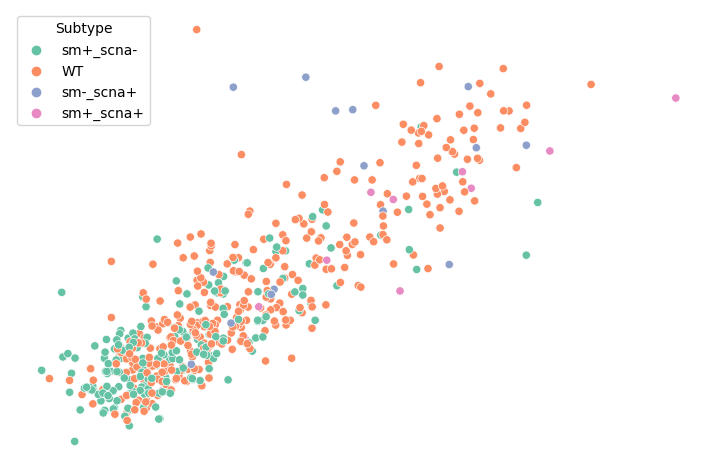

In [28]:
fig, ax = plt.subplots(figsize=(9, 6), dpi=100)

df2 = dff[dff.cancer == 'BRCA']
for ix, iy in zip(indexes, brca_subs):
    df2.loc[ix, 'cancer'] = iy

# df2.cancer = df2['cancer'].str[5:]
df2.columns = ['PC1', 'PC2', 'Subtype']

sns.scatterplot(data=df2, x='PC1', y='PC2', hue='Subtype', palette='Set2', ax=ax)

for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
    
# for r in df2.groupby('cancer').mean().iterrows():
#     label = r[0]
#     x = 0
#     y = 0
#     if label != 'BRCA':
#         if 'Normal' in label:
#             y = 0.2
#         ax.annotate(r[0], 
#                 (r[1].PC1+x, r[1].PC2+y),
#                 horizontalalignment='center',
#                 verticalalignment='center',
#                 size=7, weight='bold',)

# ax.get_legend().remove()
plt.axis('off')
# plt.title('Pathways PCA Decomposition')
# plt.savefig('BRCA_PCA.svg', format='svg', dpi=1200)

plt.show()

In [29]:
model.can_size

21

In [10]:
hnsc = pd.read_csv('https://media.githubusercontent.com/media/cBioPortal/datahub/master/public/hnsc_tcga_pan_can_atlas_2018/data_clinical_patient.txt', sep='\t')
hnsc = hnsc[['#Patient Identifier', 'Subtype']][4:]
# hnsc = hnsc.set_index('#Patient Identifier')
# hnsc.index.name = None
hnsc

,#Patient Identifier,Subtype
4,TCGA-4P-AA8J,HNSC_HPV-
5,TCGA-BA-4074,HNSC_HPV-
6,TCGA-BA-4076,HNSC_HPV-
7,TCGA-BA-4078,HNSC_HPV-
8,TCGA-BA-5149,HNSC_HPV-
...,...,...
522,TCGA-UF-A7JT,HNSC_HPV-
523,TCGA-UF-A7JV,HNSC_HPV-
524,TCGA-UP-A6WW,HNSC_HPV+
525,TCGA-WA-A7GZ,HNSC_HPV-


In [11]:
indexes2 = []
hnsc_subs = []

for tmr, subtype in hnsc.values:
    if tmr in dataset['tmr']:
        indexes2.append(dataset['tmr'].index(tmr))
        hnsc_subs.append(subtype)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

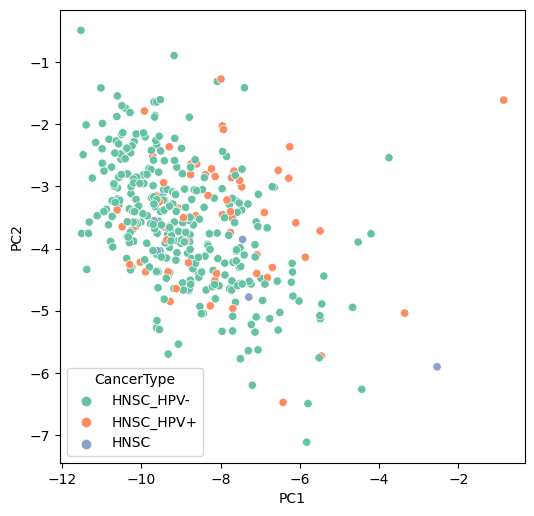

In [12]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

df2 = dff[dff.cancer == 'HNSC']
for ix, iy in zip(indexes2, hnsc_subs):
    df2.loc[ix, 'cancer'] = iy

df2

# df2.cancer = df2['cancer'].str[5:]
df2.columns = ['PC1', 'PC2', 'CancerType']

sns.scatterplot(data=df2, x='PC1', y='PC2', hue='CancerType', palette='Set2', ax=ax)

# for spine in plt.gca().spines.values():
#     spine.set_visible(False)
    

# # ax.get_legend().remove()
# plt.axis('off')
# # plt.title('Pathways PCA Decomposition')
# # plt.savefig('BRCA_PCA.svg', format='svg', dpi=1200)
# plt.show()


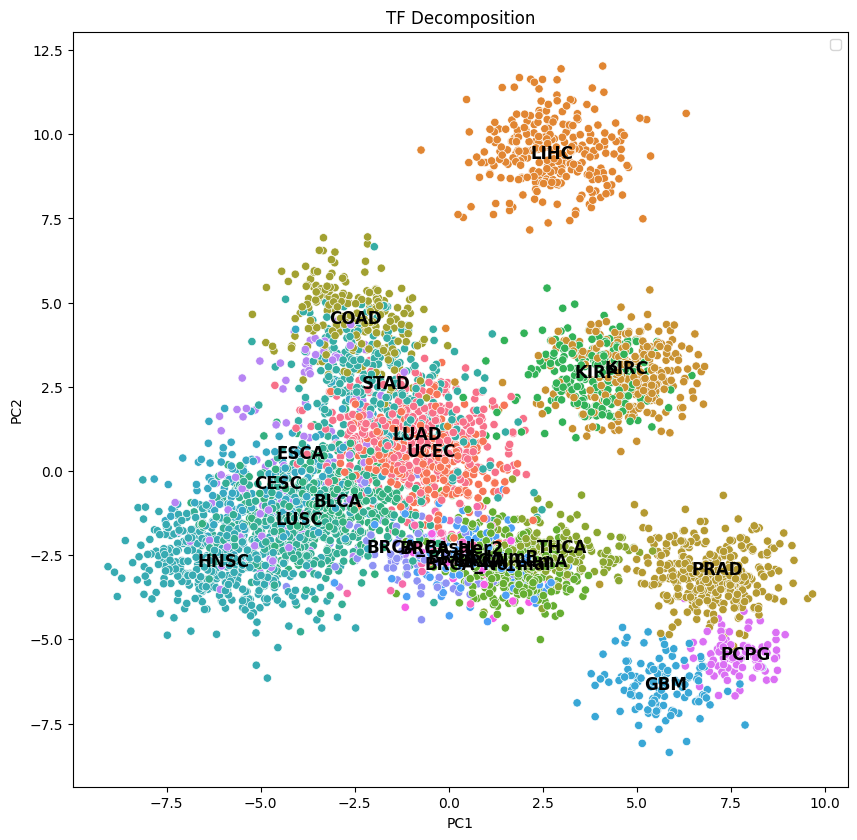

In [13]:


pca = PCA(n_components=2)
pca.fit(hid_tmr.detach().cpu().numpy())
dff = pd.DataFrame(pca.transform(hid_tmr.detach().cpu().numpy()))
dff.columns = ['PC1', 'PC2']
dff['cancer'] = d.loc[dataset['tmr']]['type'].values

for ix, iy in zip(indexes, brca_subs):
    dff.loc[ix, 'cancer'] = iy

plt.figure(figsize=(10, 10), dpi=100)
sns.scatterplot(data=dff, x='PC1', y='PC2', hue='cancer')

for r in dff.groupby('cancer').mean().iterrows():
    label = r[0]
    
    plt.annotate(r[0], 
            (r[1].PC1+np.random.uniform() / 5, r[1].PC2+np.random.uniform() / 5),
            horizontalalignment='center',
            verticalalignment='center',
            size=12, weight='bold',)

plt.legend('')
plt.title('TF Decomposition')
# plt.savefig('PCA_TF.png', dpi=180)
plt.show()

In [14]:
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients

In [15]:
from tqdm.notebook import tqdm

In [16]:
model.analysis()

In [17]:
import requests
from bs4 import BeautifulSoup
from bs4 import BeautifulSoup

def get_name(pathway):
    url = 'https://reactome.org/content/detail/' + pathway
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    try:
        return soup.find_all('h3')[0].text.strip()
    except:
        return None

In [18]:
cancers = dict(zip(d.drop_duplicates()['type'], d.drop_duplicates()['index']))

In [19]:
list(data.gene_tf_sga.index).index('PIK3CA')

5056

In [20]:
_df = pd.read_csv('/ihome/hosmanbeyoglu/kor11/tools/CITRUS/data/brca_tcga_pan_can_atlas_2018_clinical_data.tsv', sep='\t')
s = set(_df['Patient ID'])
idx = np.where(test_set['can'] < 6)[0]
overlap = set(np.array(test_set['tmr'])[idx]).intersection(s)

In [21]:
_df[_df['Patient ID'].isin(overlap)][['Patient ID', 'Subtype']].Subtype.value_counts()

BRCA_LumA      109
BRCA_LumB       32
BRCA_Basal      31
BRCA_Her2       14
BRCA_Normal      7
Name: Subtype, dtype: int64

In [22]:
xdf = pd.DataFrame(enumerate(test_set['tmr']))
xdf.columns = ['idx', 'id']

In [23]:
dataset['tmr'].__len__()

4642

In [24]:
d = data.cancerType_sga.loc[dataset['tmr']]
d['index'] = dataset['can'].reshape(-1)
db = pd.DataFrame(index=dataset['tmr']).join(d)
db.columns = ['cancer_type', 'index']
db


,cancer_type,index
TCGA-55-8206,LUAD,7
TCGA-D1-A163,UCEC,17
TCGA-DD-A1EE,LIHC,15
TCGA-B0-5698,KIRC,9
TCGA-V1-A8MJ,PRAD,11
...,...,...
TCGA-RA-A741,CESC,18
TCGA-IC-A6RF,ESCA,22
TCGA-97-8552,LUAD,7
TCGA-B0-4852,KIRC,9


In [25]:
from scipy.stats import ttest_1samp as ttest

  0%|          | 0/5 [00:00<?, ?it/s]

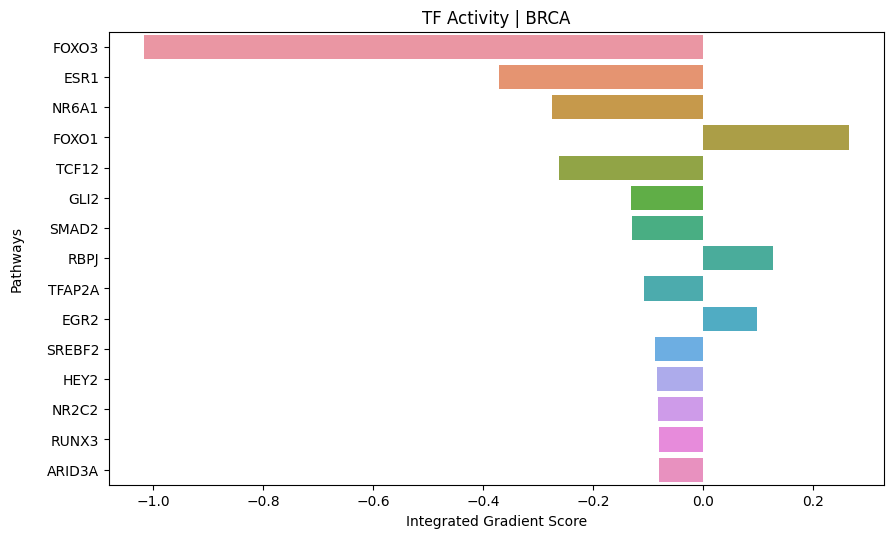

In [26]:
lc = LayerConductance(model, model.genes)
scores = []
CANCER = 'BRCA'
# idx = np.where(test_set['can'] == cancers[CANCER])[0]

idx = xdf[xdf.id.isin(_df[(_df['Patient ID'].isin(overlap)) & (_df['Subtype'] == 'BRCA_LumA')][['Patient ID', 'Subtype']]['Patient ID'])].idx.values

G = [i.split('_')[1] for i in data.sga_sga.loc[d[d['type']==CANCER].index].sum(0).sort_values(ascending=False)[:10].index]

X = torch.from_numpy(test_set['sga'])
for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
    a = lc.attribute((X[idx], torch.from_numpy(test_set['can'][idx])), n_steps=3, 
                     attribute_to_layer_input=False, target=[ix]*len(X[idx]))
    ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    scores.append(ig_attr_test_norm_sum)
    
    del a
    del ig_attr_test_sum
    del ig_attr_test_norm_sum
    
g = np.array(masks[0].index)
at = np.sum(scores, 0)

assert g.shape == at.shape

df = pd.DataFrame([g, at]).T
df.columns = ['label', 'score']
df['absolute_score'] = abs(df.score)
dfx = df.sort_values(by='absolute_score', ascending=False)[:15]


plt.figure(figsize=(10, 6), dpi=100)
sns.barplot(data=dfx.dropna(), y='label', x='score')
plt.ylabel('Pathways\n')
plt.xlabel('Integrated Gradient Score')
plt.title(f'TF Activity | {CANCER}')
plt.show()

In [27]:

lc = LayerConductance(model, model.genes)
scores = []
subtype_scores = []

CANCER = 'BRCA'

for FOCUS in ['BRCA_Basal', 'BRCA_Her2', 'BRCA_LumA', 'BRCA_LumB', 'BRCA_Normal']:
    idx = xdf[xdf.id.isin(_df[(_df['Patient ID'].isin(overlap)) & (_df['Subtype'] == FOCUS)][['Patient ID', 'Subtype']]['Patient ID'])].idx.values

    G = [i.split('_')[1] for i in data.sga_sga.loc[d[d['type']==CANCER].index].sum(0).sort_values(ascending=False)[:10].index]
    for ix in [list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]:
        a = lc.attribute((X[idx], torch.from_numpy(test_set['can'][idx])), n_steps=3, 
                        attribute_to_layer_input=True, target=[ix]*len(X[idx]))
        ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
        ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
        scores.append(ig_attr_test_norm_sum)
        
        del a
        del ig_attr_test_sum
        del ig_attr_test_norm_sum
        
        
    g = np.array(masks[0].columns)
    at = np.sum(scores, 0)

    assert g.shape == at.shape

    df = pd.DataFrame([g, at]).T
    df.columns = ['label', FOCUS]
    # df['absolute_score'] = abs(df.score)
    # dfx = df.sort_values(by='absolute_score', ascending=False)[:15]
    # dfx['pathway'] = dfx.label.apply(lambda x: get_name(x))
    # abs(dfx).dropna()
    
    subtype_scores.append(df)

    # plt.figure(figsize=(10, 6), dpi=100)
    # sns.barplot(data=dfx.dropna(), y='pathway', x='absolute_score')
    # plt.ylabel('Pathways\n')
    # plt.xlabel('Integrated Gradient Score')
    # plt.title(f'BRCA | {FOCUS}')
    # plt.show()

In [172]:
dd = pd.concat(subtype_scores, axis=1)
dd.index = df.label
dd = dd.drop('label', axis=1)
dd = dd.loc[abs(dd).sum(1).sort_values(ascending=False)[:20].index]
dd.index.name = None
dd.index = list(map(get_name, dd.index.values))
dd = dd.astype(np.float64)
dd.columns = [i[5:] for i in dd.columns]

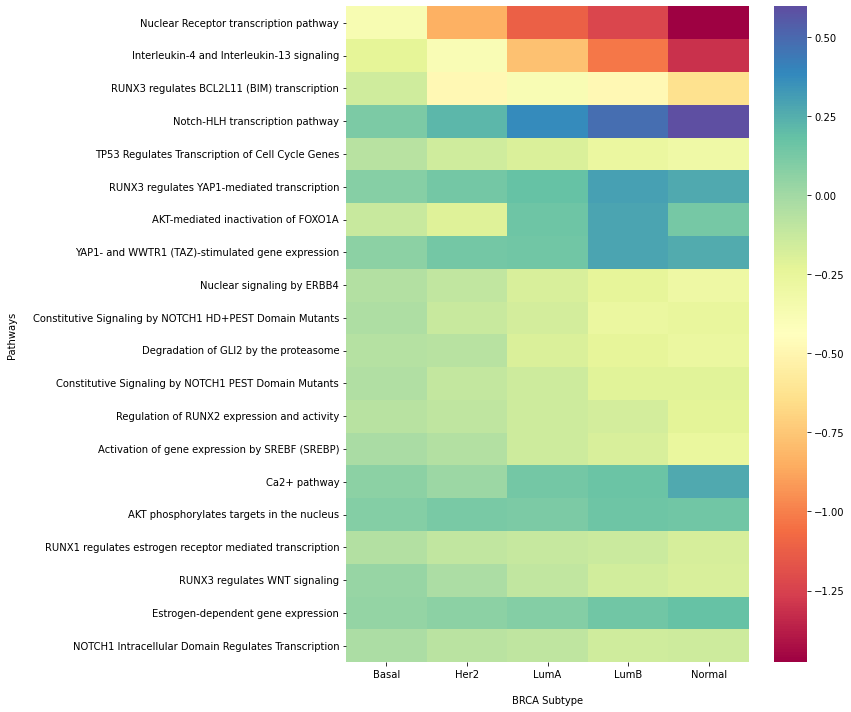

In [188]:
plt.figure(figsize=(12, 10))
sns.heatmap(data=dd, cmap='Spectral')
plt.xlabel('\nBRCA Subtype')
plt.ylabel('Pathways\n')
plt.tight_layout()
plt.savefig('Pathways_BRCA2.svg', format='svg', dpi=1200)
plt.show()

In [199]:
brca = pd.DataFrame(data.sga_sga.loc[data.cancerType_sga[data.cancerType_sga['type']=='BRCA'].index]['SM_PIK3CA'])

In [200]:
brca[brca.SM_PIK3CA==0].shape, brca[brca.SM_PIK3CA==1].shape

((455, 1), (265, 1))

  0%|          | 0/5 [00:00<?, ?it/s]

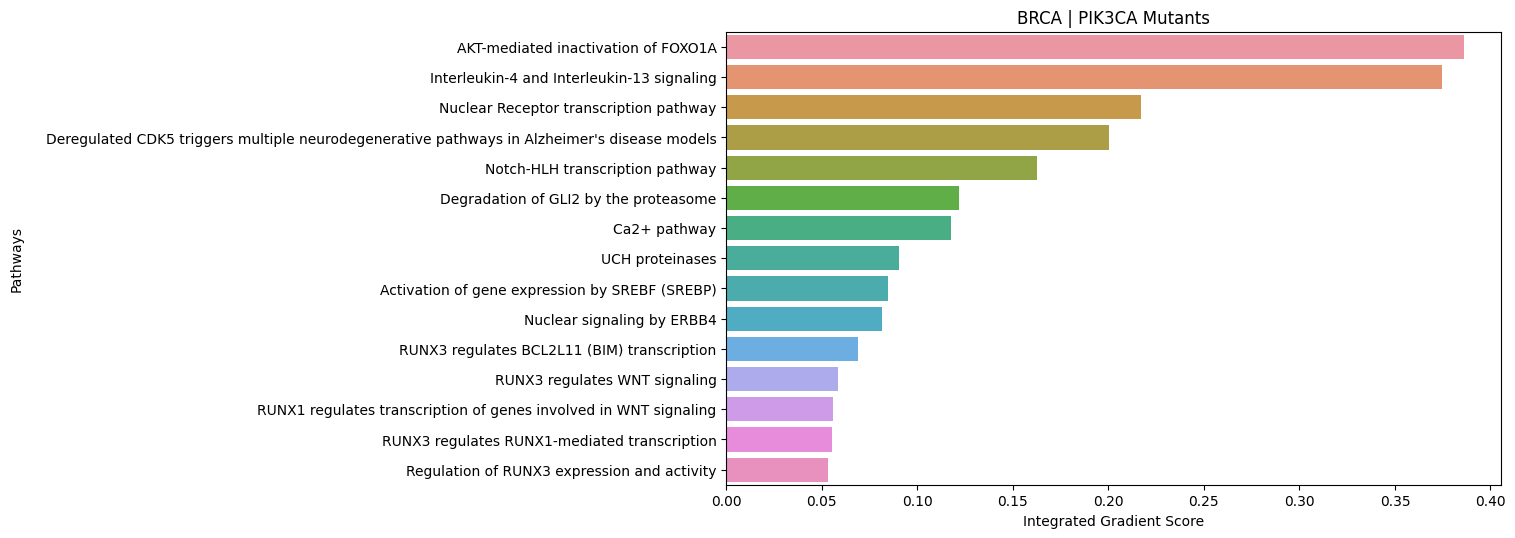

In [201]:
lc = LayerConductance(model, model.genes)
scores = []
CANCER = 'BRCA'
# idx = np.where(test_set['can'] == cancers[CANCER])[0]
idx = xdf[xdf.id.isin(brca[brca.SM_PIK3CA==1].index)].idx.values

G = [i.split('_')[1] for i in data.sga_sga.loc[d[d['type']==CANCER].index].sum(0).sort_values(ascending=False)[:10].index]
for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
    a = lc.attribute((X[idx], torch.from_numpy(test_set['can'][idx])), n_steps=3, 
                     attribute_to_layer_input=True, target=[ix]*len(X[idx]))
    ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    scores.append(ig_attr_test_norm_sum)
    
    del a
    del ig_attr_test_sum
    del ig_attr_test_norm_sum
    
    
g = np.array(masks[0].columns)
at = np.sum(scores, 0)

assert g.shape == at.shape

df = pd.DataFrame([g, at]).T
df.columns = ['label', 'score']
df['absolute_score'] = abs(df.score)
dfx = df.sort_values(by='absolute_score', ascending=False)[:15]
dfx['pathway'] = dfx.label.apply(lambda x: get_name(x))
# abs(dfx).dropna()

plt.figure(figsize=(10, 6), dpi=100)
sns.barplot(data=dfx.dropna(), y='pathway', x='absolute_score')
plt.ylabel('Pathways\n')
plt.xlabel('Integrated Gradient Score')
plt.title('BRCA | PIK3CA Mutants')
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

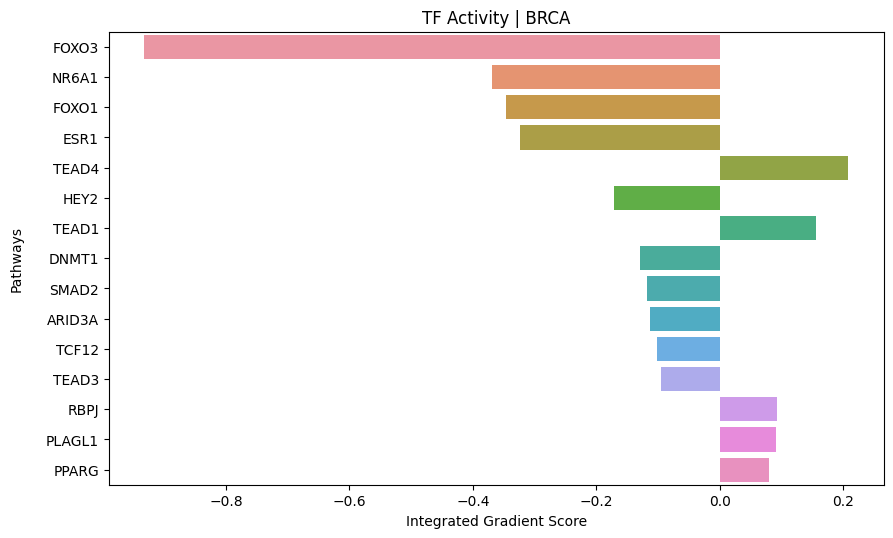

In [202]:
lc = LayerConductance(model, model.genes)
scores = []
CANCER = 'BRCA'
idx = xdf[xdf.id.isin(brca[brca.SM_PIK3CA==0].index)].idx.values

G = [i.split('_')[1] for i in data.sga_sga.loc[d[d['type']==CANCER].index].sum(0).sort_values(ascending=False)[:10].index]

for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
    a = lc.attribute((X[idx], torch.from_numpy(test_set['can'][idx])), n_steps=3, 
                     attribute_to_layer_input=False, target=[ix]*len(X[idx]))
    ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    scores.append(ig_attr_test_norm_sum)
    
    del a
    del ig_attr_test_sum
    del ig_attr_test_norm_sum
    
g = np.array(masks[0].index)
at = np.sum(scores, 0)

assert g.shape == at.shape

df = pd.DataFrame([g, at]).T
df.columns = ['label', 'score']
df['absolute_score'] = abs(df.score)
dfx = df.sort_values(by='absolute_score', ascending=False)[:15]


plt.figure(figsize=(10, 6), dpi=100)
sns.barplot(data=dfx.dropna(), y='label', x='score')
plt.ylabel('Pathways\n')
plt.xlabel('Integrated Gradient Score')
plt.title(f'TF Activity | {CANCER}')
plt.show()

In [29]:
X = torch.from_numpy(dataset['sga'])

In [30]:
xdf = pd.DataFrame(enumerate(dataset['tmr']))
xdf.columns = ['idx', 'id']
brca = pd.DataFrame(data.sga_sga.loc[data.cancerType_sga[data.cancerType_sga['type']=='BRCA'].index]['SM_PIK3CA'])

In [199]:
AA = []
results = []

lc = LayerConductance(model, model.genes)

for i in [0, 1]:
    scores = []
    CANCER = 'BRCA'
    idx = xdf[xdf.id.isin(brca[brca.SM_PIK3CA==i].index)].idx.values

    G = [i.split('_')[1] for i in data.sga_sga.loc[d[d['type']==CANCER].index].sum(0).sort_values(ascending=False)[:10].index]

    for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
        a = lc.attribute((X[idx], torch.from_numpy(dataset['can'][idx])), n_steps=5, 
                        attribute_to_layer_input=False, target=[ix]*len(X[idx]))
        ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
        ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
        scores.append(ig_attr_test_norm_sum)
        
    AA.append(a)
    g = np.array(masks[0].index)
    at = np.sum(scores, 0)

    assert g.shape == at.shape

    df = pd.DataFrame([g, at]).T
    df.columns = ['TF', f'score_{i}']
    results.append(df.set_index('TF'))

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
from scipy.stats import ttest_ind

In [92]:
tf = results[0].join(results[1]).astype(np.float64)
tf['logFC'] = np.log2(abs(tf['score_0']) / abs(tf['score_1']))
tf['pvalue'] = [ttest_ind(AA[0][:, i].detach().numpy(), AA[1][:, i].detach().numpy()).pvalue for i in range(320)]
# tf['pvalue'] = -1 * np.log10(tf['pvalue'])

tf = tf.dropna().sort_values(by='logFC', ascending=False)
tf = tf.reset_index()

In [168]:
hue = []
for fc, lp in  tf[['logFC', '-logP']].values:
    if fc > 1 and lp > 1.3:
        hue.append('Up')
    elif fc < -1 and lp > 1.3:
        hue.append('Down')
    else:
        hue.append('NA')

In [169]:
tf['hue'] = hue

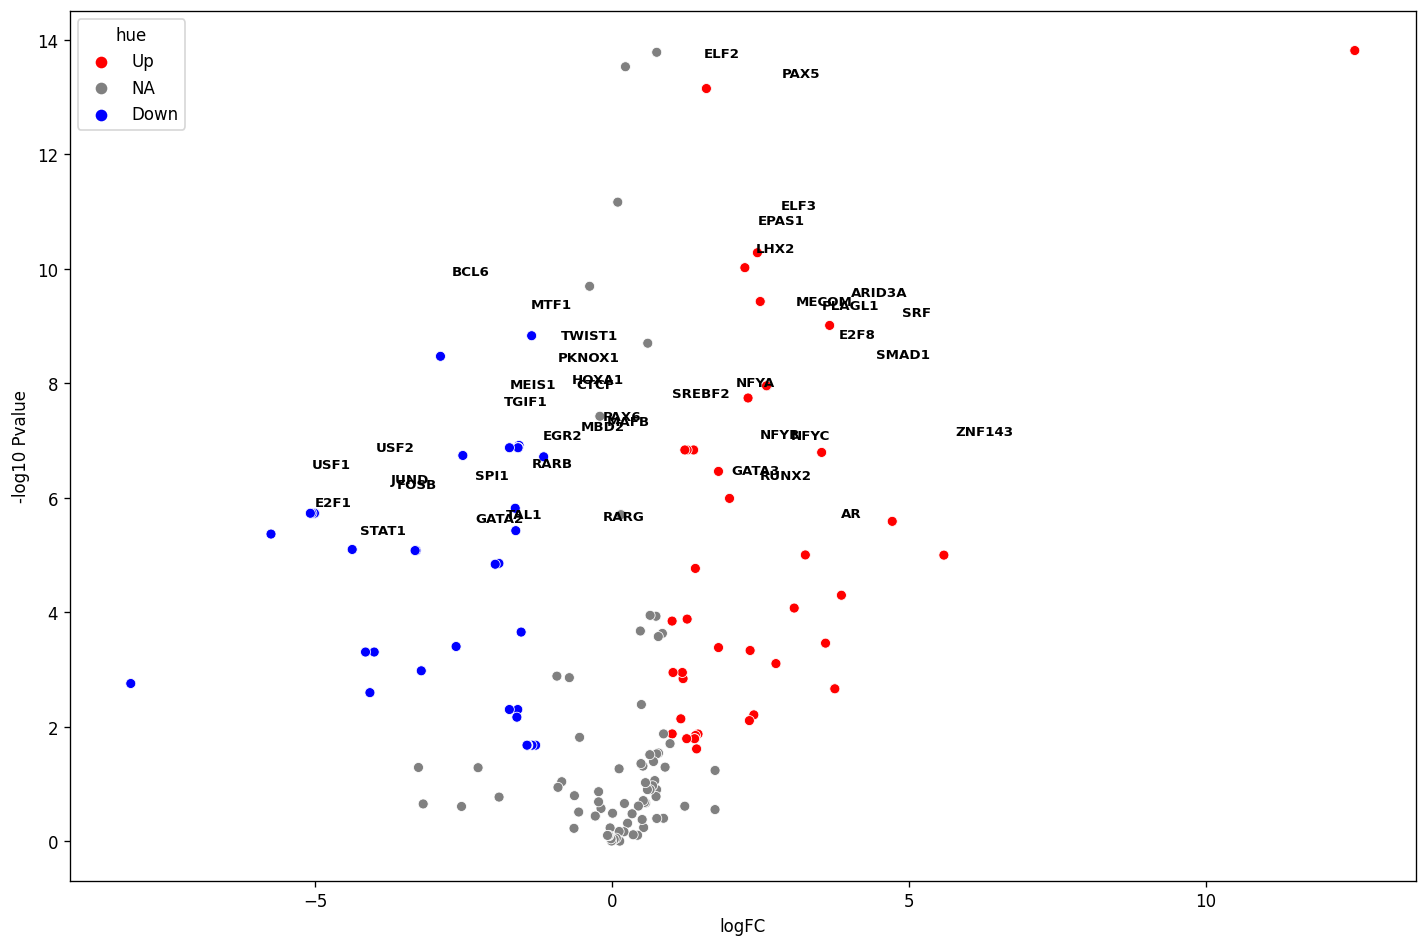

In [198]:
plt.figure(figsize=(12, 8), dpi=120)
tf['-log10 Pvalue'] = np.log10(tf['pvalue']) * -1
sns.scatterplot(data=tf, x='logFC', y='-log10 Pvalue', hue='hue', palette=('red', 'grey', 'blue'))

for r in tf.iterrows():
    label = r[1].TF
    if r[1].hue != 'NA' and r[1]['-logP'] > 5:
        
        plt.annotate(label, 
                (r[1].logFC+np.random.uniform(0, 2), r[1]['-logP']+np.random.uniform(0, 2)),
                horizontalalignment='center',
                verticalalignment='center',
                size=8, weight='bold',)
plt.tight_layout()
plt.savefig('volcano.png', dpi=180)
plt.show()

In [31]:
AA = []
results = []

lc = LayerConductance(model, model.genes)

for i in [0, 1]:
    scores = []
    CANCER = 'BRCA'
    idx = xdf[xdf.id.isin(brca[brca.SM_PIK3CA==i].index)].idx.values

    G = [i.split('_')[1] for i in data.sga_sga.loc[d[d['type']==CANCER].index].sum(0).sort_values(ascending=False)[:10].index]

    for ix in tqdm([list(data.gep_sga.columns).index(g) for g in G if g in data.gep_sga.columns]):
        a = lc.attribute((X[idx], torch.from_numpy(dataset['can'][idx])), n_steps=5, 
                        attribute_to_layer_input=True, target=[ix]*len(X[idx]))
        ig_attr_test_sum = a.detach().cpu().numpy().sum(0)
        ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
        scores.append(ig_attr_test_norm_sum)
        
    AA.append(a)
    
    g = np.array(masks[0].columns)
    at = np.sum(scores, 0)

    assert g.shape == at.shape

    df = pd.DataFrame([g, at]).T
    df.columns = ['Pathways', f'score_{i}']
    results.append(df.set_index('Pathways'))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [45]:
pth = results[0].join(results[1]).astype(np.float64)
pth['logFC'] = np.log2(abs(pth['score_0']) / abs(pth['score_1']))
pth['pvalue'] = [ttest_ind(AA[0][:, i].detach().numpy(), AA[1][:, i].detach().numpy()).pvalue for i in range(1387)]
pth['-logP'] = -1 * np.log10(pth['pvalue'])

pth = pth.dropna().sort_values(by='logFC', ascending=False)
pth = pth.reset_index()

hue = []
for fc, lp in  pth[['logFC', '-logP']].values:
    if fc > 1 and lp > 1.3:
        hue.append('Up')
    elif fc < -1 and lp > 1.3:
        hue.append('Down')
    else:
        hue.append('NA')
        

pth['hue'] = hue

In [52]:
pth['Pathways'] = pth['Pathways'].apply(lambda x: get_name(x))

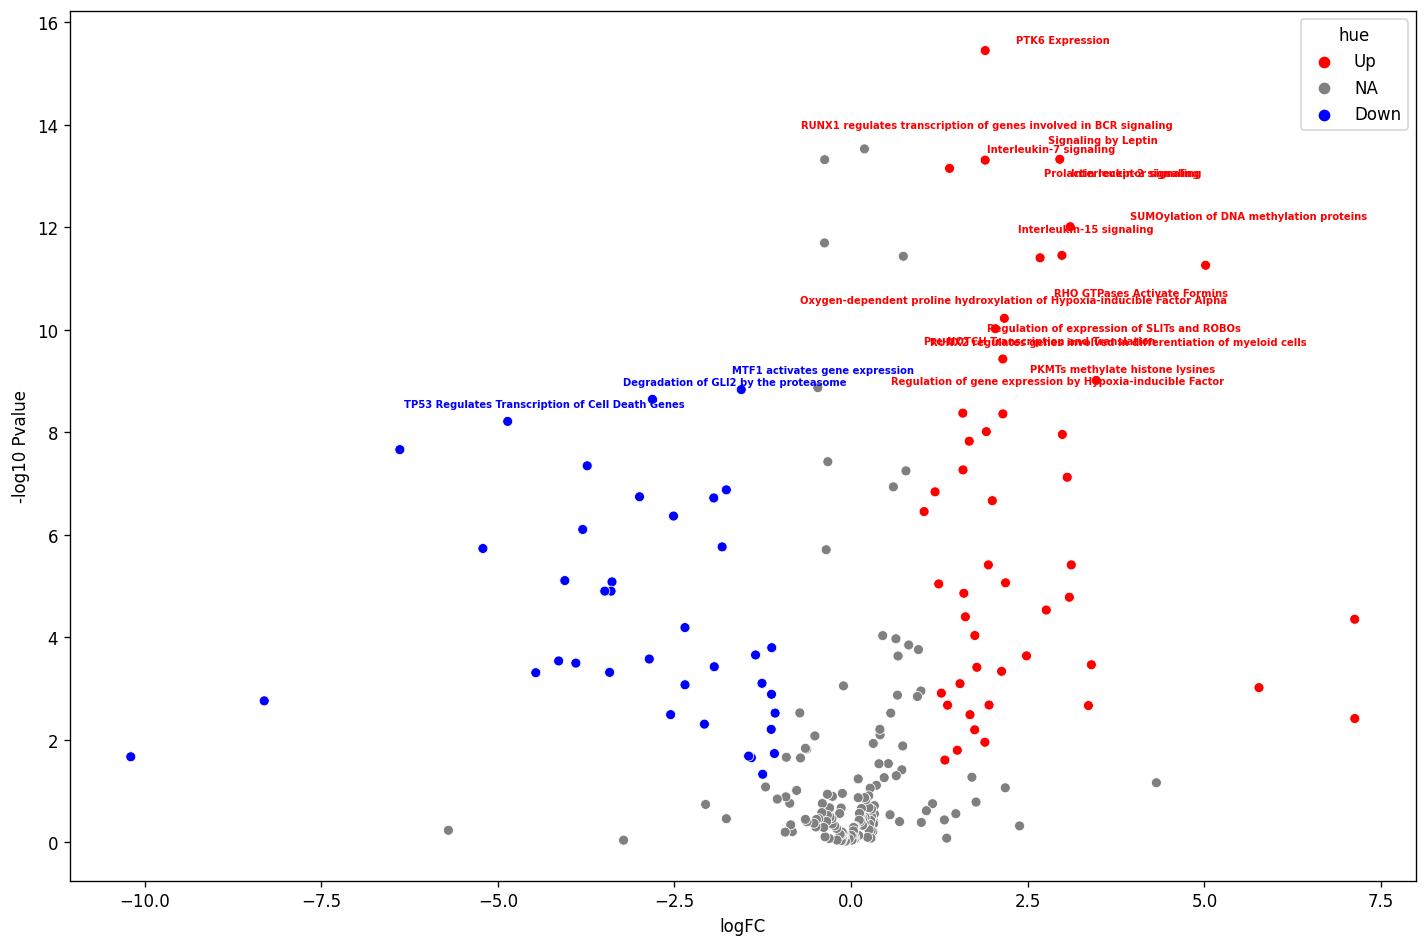

In [74]:
plt.figure(figsize=(12, 8), dpi=120)
pth['-log10 Pvalue'] = np.log10(pth['pvalue']) * -1
sns.scatterplot(data=pth, x='logFC', y='-log10 Pvalue', hue='hue', palette=('red', 'grey', 'blue'))

for r in pth.iterrows():
    label = r[1]['Pathways']
    c = 'grey'
    if r[1].hue != 'NA' and r[1]['-logP'] > 8:
        if r[1].hue == 'Up':
            c = 'red'
        if r[1].hue == 'Down':
            c = 'blue'
        plt.annotate(label, 
                (r[1].logFC+np.random.uniform(0, 2), r[1]['-logP']+np.random.uniform(0, 2)),
                horizontalalignment='center',
                verticalalignment='center',
                size=6, weight='bold', color=c)
plt.tight_layout()
plt.savefig('pathways_volcano.png', dpi=180)
plt.show()

In [63]:
pth[(pth.hue != 'NA')][['Pathways', 'logFC', '-logP']].to_csv('pathways_pik3ca_mut_vs_wt.csv', index=None)

In [33]:
import torch
###################################################################################
## main ##
import pickle
import numpy as np
from collections import defaultdict as dd
from collections import Counter
import pandas as pd

#from sklearn.metrics import r2_score
from scipy import stats

import operator
import matplotlib.pyplot as plt
from adjustText import adjust_text

from termcolor import colored #color print for non-driver
     
epsilon = 1e-6

size_label = 15
size_title = 15
size_legend = 8
size_tick = 10

stratified = False
known_driver = set(['ABL1','ACVR1','ACVR1B','ACVR2A','ACVR2A','ACVR2A','AJUBA','AJUBA','AKT1','AKT1','AKT1','AKT1','AKT1','AKT1','ALB','ALK','AMER1','AMER1','APC','APC','APC','APC','APOB','AR','ARAF','ARHGAP35','ARHGAP35','ARHGAP35','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID1A','ARID2','ARID2','ARID2','ARID2','ARID2','ARID2','ARID5B','ASXL1','ASXL1','ASXL2','ASXL2','ATF7IP','ATF7IP','ATM','ATM','ATM','ATM','ATM','ATR','ATR','ATRX','ATRX','ATRX','ATRX','ATRX','ATXN3','AXIN1','AXIN1','AXIN2','B2M','B2M','BAP1','BAP1','BAP1','BAP1','BAP1','BAP1','BAP1','BCL2','BCL2L11','BCOR','BCOR','BCOR','BRAF','BRAF','BRAF','BRAF','BRAF','BRAF','BRAF','BRCA1','BRCA1','BRCA1','BRCA2','BRD7','BRD7','BRD7','BTG2','CACNA1A','CARD11','CASP8','CASP8','CASP8','CASP8','CASP8','CBFB','CBFB','CBWD3','CCND1','CCND1','CD70','CD79B','CDH1','CDH1','CDH1','CDK12','CDK12','CDK4','CDK4','CDKN1A','CDKN1A','CDKN1A','CDKN1B','CDKN1B','CDKN2A','CDKN2A','CDKN2A','CDKN2A','CDKN2A','CDKN2A','CDKN2A','CDKN2A','CDKN2A','CDKN2A','CDKN2C','CEBPA','CHD3','CHD3','CHD4','CHD4','CHD4','CHD4','CHD8','CHEK2','CIC','CIC','CNBD1','COL5A1','CREB3L3','CREBBP','CREBBP','CSDE1','CTCF','CTCF','CTCF','CTNNB1','CTNNB1','CTNNB1','CTNNB1','CTNNB1','CTNNB1','CTNNB1','CTNNB1','CTNNB1','CTNNB1','CTNND1','CTNND1','CUL1','CUL1','CUL3','CUL3','CUL3','CUL3','CYLD','CYSLTR2','DACH1','DAZAP1','DDX3X','DDX3X','DHX9','DIAPH2','DICER1','DMD','DNMT3A','DNMT3A','DNMT3A','EEF1A1','EEF1A1','EEF2','EGFR','EGFR','EGFR','EGFR','EGR3','EIF1AX','EIF1AX','EIF1AX','ELF3','ELF3','EP300','EP300','EP300','EP300','EP300','EP300','EPAS1','EPHA2','EPHA2','EPHA2','EPHA3','ERBB2','ERBB2','ERBB2','ERBB2','ERBB2','ERBB2','ERBB2','ERBB3','ERBB3','ERBB3','ERBB3','ERBB4','ERCC2','ERCC2','ESR1','EZH2','FAM46D','FAT1','FAT1','FAT1','FAT1','FAT1','FAT1','FBXW7','FBXW7','FBXW7','FBXW7','FBXW7','FBXW7','FBXW7','FBXW7','FBXW7','FBXW7','FBXW7','FGFR1','FGFR2','FGFR2','FGFR2','FGFR3','FGFR3','FGFR3','FLNA','FLT3','FOXA1','FOXA1','FOXA1','FOXA1','FOXA2','FOXA2','FOXQ1','FUBP1','FUBP1','GABRA6','GATA3','GATA3','GNA11','GNA11','GNA11','GNA13','GNAQ','GNAQ','GNAS','GNAS','GNAS','GPS2','GPS2','GRIN2D','GTF2I','GTF2I','H3F3A','H3F3C','HGF','HIST1H1C','HIST1H1E','HIST1H1E','HLA-A','HLA-A','HLA-A','HLA-B','HLA-B','HLA-B','HLA-B','HRAS','HRAS','HRAS','HRAS','HRAS','HRAS','HRAS','HRAS','HRAS','HUWE1','IDH1','IDH1','IDH1','IDH1','IDH1','IDH1','IDH1','IDH1','IDH2','IDH2','IDH2','IL6ST','IL7R','INPPL1','INPPL1','IRF2','IRF6','JAK1','JAK2','JAK3','KANSL1','KANSL1','KANSL1','KDM5C','KDM5C','KDM6A','KDM6A','KDM6A','KDM6A','KDM6A','KDM6A','KDM6A','KEAP1','KEAP1','KEAP1','KEAP1','KEAP1','KEL','KIF1A','KIT','KIT','KIT','KIT','KLF5','KLF5','KLF5','KLF5','KMT2A','KMT2B','KMT2B','KMT2C','KMT2C','KMT2C','KMT2C','KMT2C','KMT2D','KMT2D','KMT2D','KMT2D','KMT2D','KMT2D','KMT2D','KMT2D','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRAS','KRT222','LATS1','LATS2','LEMD2','LZTR1','LZTR1','MACF1','MAP2K1','MAP2K1','MAP2K4','MAP2K4','MAP3K1','MAP3K1','MAP3K1','MAP3K1','MAP3K4','MAPK1','MAPK1','MAPK1','MAX','MAX','MECOM','MED12','MEN1','MET','MET','MGA','MGA','MGMT','MLH1','MSH2','MSH3','MSH6','MTOR','MTOR','MUC6','MYC','MYCN','MYD88','MYH9','NCOR1','NCOR1','NF1','NF1','NF1','NF1','NF1','NF1','NF1','NF1','NF1','NF2','NF2','NF2','NFE2L2','NFE2L2','NFE2L2','NFE2L2','NFE2L2','NFE2L2','NFE2L2','NFE2L2','NIPBL','NIPBL','NOTCH1','NOTCH1','NOTCH1','NOTCH1','NOTCH1','NOTCH1','NOTCH2','NPM1','NRAS','NRAS','NRAS','NRAS','NRAS','NRAS','NRAS','NRAS','NRAS','NRAS','NRAS','NSD1','NSD1','NSD1','NUP133','NUP93','PAX5','PBRM1','PBRM1','PBRM1','PBRM1','PCBP1','PCBP1','PDGFRA','PDS5B','PGR','PHF6','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CA','PIK3CB','PIK3CG','PIK3R1','PIK3R1','PIK3R1','PIK3R1','PIK3R1','PIK3R1','PIK3R2','PIK3R2','PIM1','PLCB4','PLCG1','PLXNB2','PMS1','PMS2','POLE','POLQ','POLRMT','PPM1D','PPP2R1A','PPP2R1A','PPP2R1A','PPP6C','PRKAR1A','PSIP1','PSIP1','PTCH1','PTCH1','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTEN','PTMA','PTMA','PTPDC1','PTPN11','PTPN11','PTPN11','PTPRC','PTPRD','RAC1','RAC1','RAC1','RAD21','RAF1','RARA','RASA1','RASA1','RASA1','RASA1','RB1','RB1','RB1','RB1','RB1','RB1','RB1','RB1','RB1','RB1','RB1','RB1','RB1','RB1','RBM10','RBM10','RBM10','RET','RFC1','RHEB','RHOA','RHOA','RHOA','RHOA','RHOB','RIT1','RNF111','RNF43','RNF43','RNF43','RPL22','RPL22','RPL5','RPS6KA3','RQCD1','RQCD1','RRAS2','RUNX1','RUNX1','RUNX1','RXRA','SCAF4','SCAF4','SETBP1','SETD2','SETD2','SETD2','SETD2','SETD2','SETD2','SF1','SF1','SF3B1','SF3B1','SF3B1','SF3B1','SF3B1','SIN3A','SIN3A','SMAD2','SMAD2','SMAD2','SMAD4','SMAD4','SMAD4','SMAD4','SMAD4','SMAD4','SMARCA1','SMARCA4','SMARCA4','SMARCA4','SMARCA4','SMARCB1','SMC1A','SMC1A','SMC3','SOS1','SOS1','SOX17','SOX17','SOX9','SOX9','SPOP','SPOP','SPOP','SPTA1','SPTAN1','SRSF2','STAG2','STAG2','STAG2','STK11','STK11','STK11','TAF1','TBL1XR1','TBX3','TBX3','TCEB1','TCF12','TCF12','TCF12','TCF7L2','TET2','TGFBR2','TGFBR2','TGFBR2','TGFBR2','TGIF1','THRAP3','TLR4','TMSB4X','TNFAIP3','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TP53','TRAF3','TSC1','TSC1','TSC2','TXNIP','U2AF1','U2AF1','U2AF1','U2AF1','U2AF1','UNCX','USP9X','VHL','VHL','WHSC1','WT1','WT1','XPO1','ZBTB20','ZBTB7B','ZC3H12A','ZCCHC12','ZFHX3','ZFP36L1','ZFP36L2','ZFP36L2','ZMYM2','ZMYM3','ZNF133','ZNF750','ZNF750','ZNF750'])

#read in cancer driver gene
# df_cancer_driver = pd.read_csv('./data/Cancer_Driver_Genes.csv')
# known_driver = list(set(df_cancer_driver["Gene"]))

In [34]:
# to run this code, there should be 10 outputs in the ./data folder, but only include *_1.pkl in this zipped file. 
# Python code generate the output as the input of R code. (Both codes plot the same things, just different styles)

def load_attnwt_freq(data, run):

          
    attnwt_list = []
    for i in range(Ntf):
        attnwt_list.append(run[i]['attn_wt'])
    
  
    idx2sga = data['idx2sga']
    sga = data['sga']    

    sga2wt_attn = dd(float)
    sga2freq = dd(float)
    for i in range(0,Ntf):
        for idx, line in enumerate(sga):
            for idy, sgaid in enumerate(line):
                
                sga2wt_attn[idx2sga[sgaid]] += attnwt_list[i][idx,idy]
                sga2freq[idx2sga[sgaid]] += 1

    attnwtSet = {'idx2sga':idx2sga,
                 'sga2wt_attn':sga2wt_attn,
                 'sga2freq':sga2freq
                }    
    
    return (attnwtSet)




def load_attnwt_freq_types(data, run):
  
    Ntf = len(run)        
    attnwt_list = []
    for i in range(Ntf):
        attnwt_list.append(run[i]['attn_wt'])
    
  
    idx2sga = data['idx2sga']
    sga = data['sga']    
    
 
    idx2can = data['idx2can']
    can2idx = {idx2can[i]:i for i in idx2can.keys()}
    can = data["can"]
    
    
    attnwtSet_types={}
    attnwt_types = {}
    for cancer_type in can2idx.keys():
        type_sample_indices = list(np.where(can == can2idx[cancer_type])[0])
        sga_type = [ sga[idx] for idx in type_sample_indices ]
     
        sga2wt_attn = dd(float)
        sga2freq = dd(float)
        
        for i in range(0,Ntf):
            for idx, line in enumerate(sga_type):
                for idy, sgaid in enumerate(line):
                    # if not shuffled:
                    #     sgaid -= 1
                    if sgaid == -1: 
                        continue
                    # if sgaid == 19669:
                    #     continue
                    sga2wt_attn[idx2sga[sgaid]] += attnwt_list[i][idx,idy]
                    sga2freq[idx2sga[sgaid]] += 1        
    
        attnwt_types[cancer_type] = {"sga2wt_attn":sga2wt_attn,
                                  "sga2freq":sga2freq
                                  }
    attnwtSet_types["idx2sga"] = idx2sga
    attnwtSet_types["types"] = attnwt_types
    
    return(attnwtSet_types)
    



def find_gene_name(sga_fullname):
    
    sga_s = sga_fullname.split("_")[-1] 
    sga_ss = sga_s.split("|")[0] 
    sga_sss = sga_ss.split(":")[0] 
    # sga_ssss = sga_sss.split("-")[0] 
    
    return(sga_sss)


def sort_k_v(k2v, top_k, idx2sga, known_driver):
    sorted_k_and_v = sorted(k2v.items(),key=operator.itemgetter(1),reverse=True)
    sorted_k = [x[0] for x in sorted_k_and_v[:top_k]]
    # print('_'*30)
    # print('')
    # print([sga for sga in sorted_k])
    driver_count = 0
    for item in sorted_k:
        if find_gene_name(item) not in known_driver:
            print(colored(item, 'white','on_red'), end=",")
        else:
            driver_count += 1
            print(item, end=",")
    print('')
    print('Number of drivers is:',driver_count, "/",top_k)
    return(sorted_k, driver_count)

def sort_k_f(k2f, top_k, known_drdiver):
    sorted_k_and_f = sorted(k2f.items(),key=operator.itemgetter(1),reverse=True)
    sorted_k = [x[0] for x in sorted_k_and_f[:top_k]]
    print("top frequently mutated genes are:")
    driver_count = 0
    for item in sorted_k:
        if find_gene_name(item) not in known_driver:
            print(colored(item, 'white','on_red'), end=",")
        else:
            driver_count += 1
            print(item, end=",")
    print('')
    print('Number of drivers is:',driver_count, "/",top_k)
    # print(sorted_k)
    return(sorted_k, driver_count)
    
def sort_k_v_stratified(k2v,freq, top_k, idx2sga):
    k2v2 = {s: k2v[s]/freq[s] for s in freq.keys()}
    sorted_k_and_v = sorted(k2v2.items(),key=operator.itemgetter(1),reverse=True)
    sorted_k = [x[0] for x in sorted_k_and_v[:top_k]]

    return(sorted_k)

def plot_attnwt(attnwtSet, stratified, known_driver, cancer_name=''):
    
    sga2wt_attn = attnwtSet['sga2wt_attn']
    sga2freq = attnwtSet['sga2freq']
    idx2sga = attnwtSet['idx2sga']
    
    
    top20_strait = sort_k_v_stratified(sga2wt_attn, sga2freq, 20, idx2sga)
    
    top20,_ = sort_k_v(sga2wt_attn, 50, idx2sga, known_driver)
    topFreq = sort_k_f(sga2freq, 50, known_driver)
    #['TP53', 'TTN', 'PIK3CA', 'CSMD3', 'MUC16', 'MUC4', 'CDKN2A', 'CSMD1', 'LRP1B', 'FRG1B', 'RYR2', 'ZFHX4', 'FLG', 'USH2A', 'PKHD1L1']
    
    
    #   #sort_k_v(sga2freq, top_k=10,string='Freq_'+cantype)
    if stratified:  
        attn, freq = zip(*[(np.log(sga2wt_attn[s]/(sga2freq[s]+epsilon)+1),np.log(1+sga2freq[s])) for s in sga2freq.keys()])
    else:
        attn, freq = zip(*[(np.log(1+sga2wt_attn[s]),np.log(1+sga2freq[s])) for s in sga2freq.keys()])
    
   
    if stratified:  
        drivers = top20_strait[:15]
    else:
        drivers = top20[:15]
    
     
    fig, ax =  plt.subplots(figsize=(10, 8), dpi=120)
    xs=[]; ys=[]
    
    ax.scatter(freq, attn, s=8, alpha=0.3, edgecolors='none')
    for g in drivers:
       if g in drivers:
            if stratified: 
                ax.scatter(np.log(1+sga2freq[g]), np.log(sga2wt_attn[g]/(sga2freq[g]+epsilon)+1),c='r', edgecolors='k')
            else:
                ax.scatter(np.log(1+sga2freq[g]), np.log(1+sga2wt_attn[g]),c='r', edgecolors='k')
                          
  
       if stratified:
           xp, yp = np.log(1+sga2freq[g]), np.log(sga2wt_attn[g]/ (sga2freq[g]+epsilon)+1)              
       else:
           xp, yp = np.log(1+sga2freq[g]), np.log(1+sga2wt_attn[g])
       # 
       xs.append(xp)
       ys.append(yp)
           
    texts = [ax.text(xs[i], ys[i], drivers[i]) for i in range(len(drivers))]
    adjust_text(texts)
    
    
    ax.scatter([],[],c='r',label='Drivers',edgecolors='k')
 
    plt.xlabel('log(Frequency+1)', fontsize=size_label)
    
    if stratified:
        plt.ylabel('log(Attention/Frequency+1)', fontsize=size_label)
    else:
        plt.ylabel('log(Attention+1)', fontsize=size_label)
        
    plt.tick_params(labelsize=size_tick)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    plt.title(cancer_name)

    # generate pkl file for ploting in R
             
    data_out = {"freq": [np.log(1+sga2freq[s]) for s in sga2freq.keys()],
            "attn": [np.log(1+sga2wt_attn[s]) for s in sga2freq.keys()],
            "attn_strait":[np.log(sga2wt_attn[s]/(sga2freq[s]+epsilon)+1) for s in sga2freq.keys()],
            "drivers": top20,
            "drivers_strait": top20_strait,
            "driverFreq": [np.log(1+sga2freq[g]) for g in top20],
            "driverAttn": [np.log(1+sga2wt_attn[g]) for g in top20],
            "driverFreq_strait": [np.log(1+sga2freq[g]) for g in top20_strait],
            "driverAttn_strait": [np.log(sga2wt_attn[g]/(sga2freq[g]+epsilon)+1) for g in top20_strait ]
            }
    return(data_out)
    

# 
def plot_attnwt_types(attnwtSet_types, stratified):

    data_out_types = {}
    data_types = {}
    idx2sga = attnwtSet_types['idx2sga']
    total_count_attnwt = 0
    total_count_freq = 0
    for item in sorted(list(attnwtSet_types['types'].keys())):
        cancer_type = item
        cancer_driver = list(df_cancer_driver.loc[df_cancer_driver['Cancer']==cancer_type,'Gene'])
        sga2wt_attn = attnwtSet_types['types'][cancer_type]['sga2wt_attn']
        sga2freq = attnwtSet_types['types'][cancer_type]['sga2freq']
        
        print('')
        print(item)      
        
        top20_strait = list(sort_k_v_stratified(sga2wt_attn, sga2freq, 20, idx2sga))

        top20, driver_count = list(sort_k_v(sga2wt_attn, 20, idx2sga,cancer_driver))
        total_count_attnwt += driver_count
        
        topFreq, count_freq = sort_k_f(sga2freq, 20, known_driver)
        total_count_freq += count_freq
        #['TP53', 'TTN', 'PIK3CA', 'CSMD3', 'MUC16', 'MUC4', 'CDKN2A', 'CSMD1', 'LRP1B', 'FRG1B', 'RYR2', 'ZFHX4', 'FLG', 'USH2A', 'PKHD1L1']
        
        
        if stratified:  
            # print("stratified is true!\n")
            attn, freq = zip(*[(np.log(sga2wt_attn[s]/(sga2freq[s]+epsilon)+1),np.log(1+sga2freq[s])) for s in sga2freq.keys()])
        else:
            # print("stratified is false!\n")
            attn, freq = zip(*[(np.log(1+sga2wt_attn[s]),np.log(1+sga2freq[s])) for s in sga2freq.keys()])
        
        
        if stratified:  
            drivers = top20_strait[:]
        else:
            drivers = top20[:10]
        
        
        fig, ax =  plt.subplots(figsize=(5,5))
        
        ax.scatter(freq, attn, s=8, alpha=0.3, edgecolors='none')
        xs=[]
        ys=[]
        for i in range(len(drivers)):
           g = drivers[i]

           if stratified:
               xp, yp = np.log(1+sga2freq[g]), np.log(sga2wt_attn[g]/ (sga2freq[g]+epsilon)+1)  
               ax.scatter(xp, yp ,c='r', edgecolors='k')
           else:
               xp, yp = np.log(1+sga2freq[g]), np.log(1+sga2wt_attn[g])
               ax.scatter(xp, yp ,c='r', edgecolors='k')
           # 
           xs.append(xp)
           ys.append(yp)
           
        
        texts = [ax.text(xs[i], ys[i], drivers[i]) for i in range(len(drivers))]
        adjust_text(texts)
       
        
        plt.xlabel('log10(Frequency+1)', fontsize=size_label)
        
        if stratified:
            plt.ylabel('log10(Attention/Frequency+1)', fontsize=size_label)
        else:
            plt.ylabel('log10(Attention+1)', fontsize=size_label)
            
        plt.tick_params(labelsize=size_tick)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)  
        plt.title(cancer_type)


        # generate pkl file for plot in R
        data_out = {"freq": [np.log(1+sga2freq[s]) for s in sga2freq.keys()],
            "attn": [np.log(1+sga2wt_attn[s]) for s in sga2freq.keys()],
            "attn_strait":[np.log(sga2wt_attn[s]/(sga2freq[s]+epsilon)+1) for s in sga2freq.keys()],
            "drivers": top20,
            "drivers_strait": top20_strait,
            "driverFreq": [np.log(1+sga2freq[g]) for g in top20],
            "driverAttn": [np.log(1+sga2wt_attn[g]) for g in top20],
            "driverFreq_strait": [np.log(1+sga2freq[g]) for g in top20_strait],
            "driverAttn_strait": [np.log(sga2wt_attn[g]/(sga2freq[g]+epsilon)+1) for g in top20_strait ]
            }

        data_types[cancer_type] = data_out 
        
    print("\nTotal driver count for attnwt is: ", total_count_attnwt)
    print("\nTotal driver count for freqency is: ", total_count_freq)
    # list of cancer type names
    data_out_types['cancer_names'] = list(attnwtSet_types['types'].keys())
    # each specific type
    data_out_types['cancer_types'] = data_types  
    
    return(data_out_types)

In [35]:
SGAmerged = False
type_specific = False

setid = '0.04'
droprate = '0.2'

# data = pickle.load( open("./data/dataset_PANunion2500_17_sga_dropped_seperated_rmNotImpt_"+setid+".pkl", "rb") )
data = pickle.load( open("/ihome/hosmanbeyoglu/kor11/tools/CITRUS/data/dataset_CITRUS.pkl", "rb") )
cancers = data['idx2can']

In [36]:
Ntf = 1
run = list()
for i in range(1, Ntf+1):
    dataset = pickle.load(open(f"/ihome/hosmanbeyoglu/kor11/tools/CITRUS/output/outputzz_dataset_CITRUS_{i}.pkl", "rb") )
    run.append(dataset)

In [37]:
len(run)

1

SM_TP53,SM_PIK3CA,SM_VHL,SM_CTNNB1,SM_APC,SM_PTEN,SM_TTN,SM_BRAF,SM_PBRM1,SM_HMCN1,SM_KRAS,SCNA_LRP1B,SCNA_PTEN,SCNA_C9orf53,SM_CSMD3,SM_KMT2D,SM_HUWE1,SM_FGFR3,SCNA_WWOX,SCNA_CDKN2A,SM_CDH1,SM_ARID1A,SM_OBSCN,SM_APOB,SM_FAT1,SCNA_CSMD1,SM_RB1,SM_CASP8,SM_CSMD2,SM_DNAH7,SM_DMD,SM_LRP2,SM_KEAP1,SM_PKHD1L1,SM_C1orf173,SM_NFE2L2,SM_BAP1,SM_NOTCH1,SM_STAG2,SCNA_FNDC3B,SM_SPAG17,SM_MYCBP2,SM_AHNAK,SCNA_TP63,SCNA_KCNMB3,SCNA_RB1,SCNA_PTPRD,SM_PIK3R1,SM_PXDNL,SM_ALB,
Number of drivers is: 30 / 50
top frequently mutated genes are:
SM_TP53,SM_TTN,SM_MUC16,SM_PIK3CA,SM_CSMD3,SM_RYR2,SCNA_CDKN2A,SCNA_C9orf53,SM_LRP1B,SM_SYNE1,SCNA_CDKN2B,SM_USH2A,SM_FLG,SM_KMT2D,SCNA_MTAP,SM_ZFHX4,SM_PCLO,SCNA_NAALADL2,SM_SPTA1,SCNA_CSMD1,SCNA_MYC,SM_OBSCN,SCNA_PVT1,SM_KMT2C,SM_ARID1A,SCNA_POU5F1B,SCNA_MECOM,SM_PTEN,SM_FAT3,SM_XIRP2,SM_DNAH5,SCNA_PIK3CA,SCNA_ZMAT3,SCNA_KCNMB2,SCNA_PEX5L,SCNA_GNB4,SCNA_MCF2L2,SCNA_MFN1,SCNA_ATP11B,SCNA_SOX2,SCNA_FNDC3B,SCNA_KCNMB3,SCNA_ZNF639,SCNA_EIF2B5,SCNA_DCUN1D1,SCNA_CLDN11,S

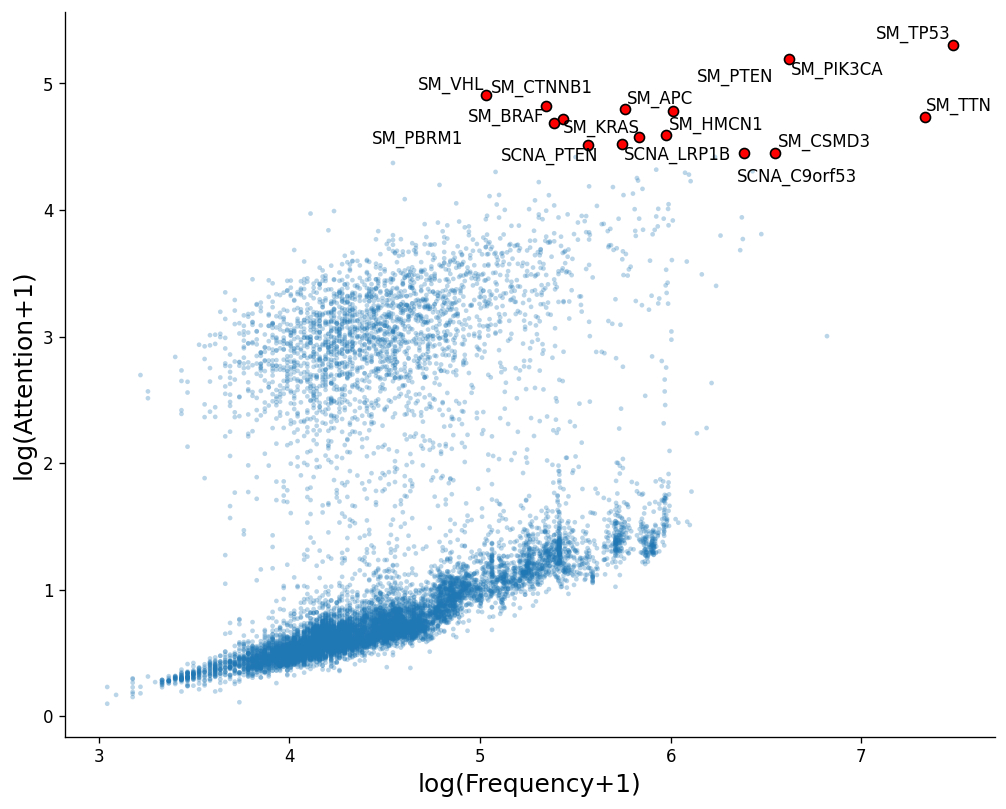

In [38]:
# for cancer_index, cancer in cancers.items():
# sga_sga = []

# for ix, m in enumerate(data['sga']):
#     if ix in set(np.where(data['can'] == cancer_index)[0]):
#         sga_sga.append(m)
            
attnwt_list = []
for i in range(Ntf):
    # attnwt_list.append(run[i]['attn_wt'][np.where(data['can'] == cancer_index)[0]])
    attnwt_list.append(run[i]['attn_wt'])
    


idx2sga = data['idx2sga']
sga = data['sga']  

sga2wt_attn = dd(float)
sga2freq = dd(float)
for i in range(0,Ntf):
    for idx, line in enumerate(sga):
        for idy, sgaid in enumerate(line):
            sga2wt_attn[idx2sga[sgaid]] += attnwt_list[i][idx,idy]
            sga2freq[idx2sga[sgaid]] += 1

attnwtSet = {
    'idx2sga':idx2sga,
    'sga2wt_attn':sga2wt_attn,
    'sga2freq':sga2freq
}    

sga2wt_attn = attnwtSet['sga2wt_attn']
sga2freq = attnwtSet['sga2freq']
idx2sga = attnwtSet['idx2sga']

top20_strait = sort_k_v_stratified(sga2wt_attn, sga2freq, 20, idx2sga)

top20,_ = sort_k_v(sga2wt_attn, 50, idx2sga, known_driver)
topFreq = sort_k_f(sga2freq, 50, known_driver)

try:

    if stratified:  
        attn, freq = zip(*[(np.log(sga2wt_attn[s]/(sga2freq[s]+epsilon)+1),np.log(1+sga2freq[s])) for s in sga2freq.keys()])
    else:
        attn, freq = zip(*[(np.log(1+sga2wt_attn[s]),np.log(1+sga2freq[s])) for s in sga2freq.keys()])


    if stratified:  
        drivers = top20_strait[:15]
    else:
        drivers = top20[:15]

        
    fig, ax =  plt.subplots(figsize=(10, 8), dpi=120)
    xs=[]; ys=[]

    ax.scatter(freq, attn, s=8, alpha=0.3, edgecolors='none')
    for g in drivers:
        if g in drivers:
            if stratified: 
                ax.scatter(np.log(1+sga2freq[g]), np.log(sga2wt_attn[g]/(sga2freq[g]+epsilon)+1),c='r', edgecolors='k')
            else:
                ax.scatter(np.log(1+sga2freq[g]), np.log(1+sga2wt_attn[g]),c='r', edgecolors='k')
                            

        if stratified:
            xp, yp = np.log(1+sga2freq[g]), np.log(sga2wt_attn[g]/ (sga2freq[g]+epsilon)+1)              
        else:
            xp, yp = np.log(1+sga2freq[g]), np.log(1+sga2wt_attn[g])
        # 
        xs.append(xp)
        ys.append(yp)
            
    texts = [ax.text(xs[i], ys[i], drivers[i]) for i in range(len(drivers))]
    adjust_text(texts)


    ax.scatter([],[],c='r',label='Drivers',edgecolors='k')

    plt.xlabel('log(Frequency+1)', fontsize=size_label)

    if stratified:
        plt.ylabel('log(Attention/Frequency+1)', fontsize=size_label)
    else:
        plt.ylabel('log(Attention+1)', fontsize=size_label)
        
    plt.tick_params(labelsize=size_tick)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # plt.title(f'{cancer} | n = {len(sga_sga)}')
    # plt.savefig(f'./plots/{cancer}.png', dpi=180)
    # plt.show()
    
except:
    pass

In [39]:
sga2attn =  attnwtSet["sga2wt_attn"]
sga2freq = attnwtSet["sga2freq"]

topFreq_idx = list(np.argsort(list(sga2freq.values()))[::-1][:100])
topFreq = np.array(list(sga2freq.values()))[topFreq_idx]
topSGAfreq = np.array(list(sga2freq.keys()))[topFreq_idx]

topAttn_idx = list(np.argsort(list(sga2attn.values()))[::-1][:100])
topAttn = np.array(list(sga2attn.values()))[topAttn_idx]
topSGAattn = np.array(list(sga2attn.keys()))[topAttn_idx]
topSGAattnPure = [find_gene_name(g) for g in topSGAattn]
topSGAfreqPure = [find_gene_name(g) for g in topSGAfreq]

driver_freq = set(known_driver) & set(topSGAfreqPure) #12
driver_attn = set(known_driver) & set(topSGAattnPure) #44

# pd.DataFrame(topSGAfreq).to_csv("./Data/topSGAfreq.csv")
# pd.DataFrame(topSGAattn).to_csv("./Data/topSGAattn.csv")

In [40]:
from scipy.stats import fisher_exact, hypergeom

def fishertest(high_SGA, low_SGA, know_driver):
    driver_high = set(known_driver) & set(high_SGA)
    driver_low = set(known_driver) & set(low_SGA)
    table_high = np.array([[len(driver_high),
                       len(driver_low)],
                      [len(high_SGA) - len(driver_high),
                       len(low_SGA) - len(driver_low)]])

    oddsr, p_high = fisher_exact(table_high, alternative='greater')

    table_low = np.array([[len(driver_low),
                       len(driver_high)],
                      [len(low_SGA) - len(driver_low),
                       len(high_SGA) - len(driver_high)]])

    oddsr_low, p_low = fisher_exact(table_low, alternative='greater')
    
    return(p_high, p_low)

############################################
# get the quantile for attention weight on all gene
sga_short = [find_gene_name(g) for g in sga2attn.keys()]
series_attn =  pd.Series(data=sga2attn.values(), index=sga_short)
summary = np.log(series_attn + 1).describe()

high_attnSGA = list(series_attn[np.log(series_attn + 1) > summary.loc['75%']].index)
low_attnSGA = list(series_attn[np.log(series_attn + 1) <= summary.loc['25%']].index)

p_high_attn, p_low_attn = fishertest(high_attnSGA, low_attnSGA, known_driver)


# find the attn wt for top freq SGAsga_short = [find_gene_name(g) for g in sga2freq.keys()]
series_freq =  pd.Series(data=sga2freq.values(), index=sga_short)
summary = np.log(series_freq + 1).describe()

high_freqSGA = list(series_freq[np.log(series_freq + 1) > summary.loc['75%']].index)
low_freqSGA = list(series_freq[np.log(series_freq + 1) <= summary.loc['25%']].index)

p_high_freq, p_low_freq = fishertest(high_freqSGA, low_freqSGA, known_driver)


###########################################################################################
attn_topSGAfreqPure = [sga2attn[g] for g in topSGAfreq]
series_attn = pd.Series(data=attn_topSGAfreqPure, index=topSGAfreqPure)
summary = np.log(series_attn+1).describe()


thred = ['25%', '50%', '75%']

index=["Percentage of drivers in high attention weight group",
                          "Percentage of drivers in low attention weight group",
                          "P-value for high attention driver",
                          "P-value for low attention driver"]


In [41]:
out = {}
for t in thred:

    sep = summary.loc[t]

    high_attnSGA = list(series_attn[np.log(series_attn + 1) > sep].index)
    low_attnSGA = list(series_attn[np.log(series_attn + 1) <= sep].index)
    len(high_attnSGA)
    len(low_attnSGA)
    driver_highAttn = set(known_driver) & set(high_attnSGA) #12
    driver_lowAttn = set(known_driver) & set(low_attnSGA) #44
    len(driver_highAttn)
    len(driver_lowAttn)

    percent_high = len(driver_highAttn)/len(high_attnSGA)
    percent_low = len(driver_lowAttn)/len(low_attnSGA)

    table_high = np.array([[len(driver_highAttn),
                       len(driver_lowAttn)],
                      [len(high_attnSGA) - len(driver_highAttn),
                       len(low_attnSGA) - len(driver_lowAttn)]])

    oddsr, p_high = fisher_exact(table_high, alternative='greater')

    table_low = np.array([[len(driver_lowAttn),
                       len(driver_highAttn)],
                      [len(low_attnSGA) - len(driver_lowAttn),
                       len(high_attnSGA) - len(driver_highAttn)]])

    oddsr_low, p_low = fisher_exact(table_low, alternative='greater')

    out[t] = [round(percent_high,2), round(percent_low,2), "{:.2E}".format(p_high),"{:.2E}".format(p_low)]

df_out = pd.DataFrame(index=index)
for t in thred:
    df_out[t] = out[t]

# df_out = df_out.round(2)

# df_out.to_csv("./Result/Driver_enrichment/Driver_enrichment_on_attnWt_test_PANCAN.csv", index=True)


In [42]:
df_out.astype(np.float64)

,25%,50%,75%
Percentage of drivers in high attention weight group,0.130,0.160,0.2800
Percentage of drivers in low attention weight group,0.080,0.080,0.0800
P-value for high attention driver,0.378,0.178,0.0166
P-value for low attention driver,0.859,0.939,0.9970
